# 05、Cifar10

这一节主要介绍新的数据集CIFAR-10，CIFAR-10和CIFAR-100是8000万个微型图像数据集的标记子集。它们由Alex Krizhevsky，Vinod Nair和Geoffrey Hinton收集。
CIFAR-10数据集包含10个类别的60000个32x32彩色图像，每个类别6000个图像。有50000张训练图像和10000张测试图像。数据集分为五个训练批次和一个测试批次，每个批次具有10000张图像。测试批次包含每个类别中恰好1000张随机选择的图像。训练批次按随机顺序包含其余图像，但是某些训练批次可能包含比另一类更多的图像。在它们之间，训练批次精确地包含每个类别的5000张图像。

然后我们将介绍更加复杂的网络主要介绍：

AlexNet，VGG，ResNet

我们使用torch自带的模型进行讲解，能不造轮子就不造轮子，官方的代码更加简洁准确。

同时将介绍如何对模型进行存储和读取，继续训练，模型预测，本节内容较长。

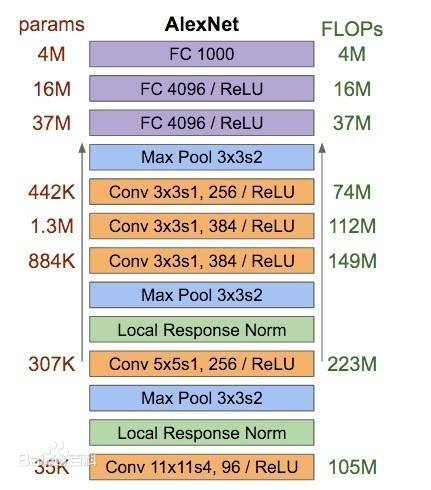

In [1]:
import torch
from torchvision import datasets
from torch import nn
import torchvision
from torchvision.transforms import transforms
import torch.optim as optim
import torch.nn.functional as F

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
     

])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = datasets.CIFAR10(root='./data', train=True,
                          download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True)


testset = datasets.CIFAR10(root='./data', train=False,
                         download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
out = (32 + 4 - 11) // 4 +1
out

In [23]:
# <python path>/Lib/site-packages/torchvision/models/alexnet.py
# 官方的模型来处理cifar10 有点不太行图片太小了  直接第一个卷积就给整的很小了，后面就难搞了，修改一下步长11改成3就没事了
# 我又改了改全连接层的神经元个数，默认使用自带的API，如果需要下面的代码训练，后面会注明使用方式。
# out = (32 + 4 - 11) // 4 +1
import torch
import torch.nn as nn


__all__ = ['AlexNet', 'alexnet']


model_urls = {
    'alexnet': 'https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth',
}


class AlexNet(nn.Module):

    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            # nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.Conv2d(3, 64, kernel_size=3, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 240),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(240, 120),
            nn.ReLU(inplace=True),
            nn.Linear(120, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


def alexnet(pretrained=False, progress=True, **kwargs):
    r"""AlexNet model architecture from the
    `"One weird trick..." <https://arxiv.org/abs/1404.5997>`_ paper.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    model = AlexNet(**kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls['alexnet'],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


## 模型构建
上面的cell构建了AlexNet网络，按照图片层层构建即可。

nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2)

nn.ReLU(inplace=True)

nn.MaxPool2d(kernel_size=3, stride=2)

- Conv2d是卷积层，API参数有：in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1,bias=True, padding_mode='zeros'，输入形状、输出形状、卷积核大小、步长、填充、设定了取数之间的间隔、组卷积、计算时是否有b，常用是前五个和最后一个组卷积核和取数间隔复杂模型法可能会用到。

- nn.ReLU(inplace=True) 随机失活部分神经元，防止过拟合用的，inplace=True是优化内存的。

- nn.MaxPool2d 是池化层对F.max_pool2d的二次封装参数有，(input, kernel_size, stride,padding, dilation, ceil_mode,return_indices)
>kernel_size(int or tuple) - max pooling的窗口大小，可以为tuple，在nlp中tuple用更多，（n,1）
stride(int or tuple, optional) - max pooling的窗口移动的步长。默认值是kernel_size
padding(int or tuple, optional) - 输入的每一条边补充0的层数
dilation(int or tuple, optional) – 一个控制窗口中元素步幅的参数
return_indices - 如果等于True，会返回输出最大值的序号，对于上采样操作会有帮助
ceil_mode - 如果等于True，计算输出信号大小的时候，会使用向上取整，代替默认的向下取整的

- nn.AdaptiveAvgPool2d,全局平局pooling，对F.adaptive_avg_pool2d二次封装参数有：input、 output_size，输入特征图和输出的维度，他会自动根据输出维度设定步长和和大小进行pooling操作。

参考：https://blog.csdn.net/qq_40210472/article/details/87895626

In [37]:
# 使用AlexNet进行训练
# AlexNet默认的参数太大了如果你不想等的时间太长可以将下面这句解除注释，把model = torchvision.models.alexnet(num_classes=10)注释掉
# model = alexnet(num_classes=10)
model = torchvision.models.alexnet(num_classes=10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
epochs = 1
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
# 在训练过程中一般一个轮次训练结束后对测试集整体进行测试，获取测试集上的损失和准确率
losses = []
acces = []
eval_losses = []
eval_acces = []
for e in range(epochs):
    train_loss = 0
    train_acc = 0
    model.train() 
    for data, target in trainloader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        # loss.item()是平均损失，平均损失*batch_size=一次训练的损失
        train_loss += loss.item() * data.size(0)  
        _, pred = output.max(1)
        # 计算一个批次对了几个
        num_correct = (pred == target).sum().item()
        # 计算准确率=对的个数/批次大小
        acc = num_correct / data.shape[0]
        train_acc += acc
    # 统计一个轮次中平均损失与平均准确率
#     losses.append(train_loss / len(trainloader.dataset))
    acces.append(train_acc / len(trainloader))
    eval_loss = 0
    eval_acc = 0
    model.eval() # 将模型改为预测模式
    for im, label in testloader:
        out = model(im)
        loss = criterion(out, label)
        # 记录误差
        eval_loss += loss.item()
        # 记录准确率
        _, pred = out.max(1)
        num_correct = (pred == label).sum().item()
        acc = num_correct / im.shape[0]
        eval_acc += acc
    # 上面的代码对全部的测试集进行测试，下面两行就是讲这一次的整个测试集的损失和准确率存在列表里,如果进行可视化可能会用到
#     eval_losses.append(eval_loss / len(testloader.dataset))
    eval_acces.append(eval_acc / len(testloader))
    print('epoch: {}, Train Loss: {:.6f}, Train Acc: {:.6f}, Eval Loss: {:.6f}, Eval Acc: {:.6f}'
          .format(e, train_loss / len(trainloader), train_acc / len(trainloader), 
                     eval_loss / len(testloader), eval_acc / len(testloader)))

In [40]:
# <python path>/Lib/site-packages/torchvision/models/vgg.py
# 先分析VGG11，结构比较简单，方面分析，我截取了一部分代码进行讲解
import torch
import torch.nn as nn

class VGG(nn.Module):

    def __init__(self, features, num_classes=1000, init_weights=True):
        super(VGG, self).__init__()
        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


cfgs = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


def _vgg(arch, cfg, batch_norm, pretrained, progress, **kwargs):
    if pretrained:
        kwargs['init_weights'] = False
    model = VGG(make_layers(cfgs[cfg], batch_norm=batch_norm), **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model

def vgg11(pretrained=False, progress=True, **kwargs):
    r"""VGG 11-layer model (configuration "A") from
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg('vgg11', 'A', False, pretrained, progress, **kwargs)

In [41]:
model = vgg11(num_classes=10)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [42]:
data = torch.rand(1, 3, 224, 224)
out = model(data)
out

tensor([[ 0.0872, -0.0684, -0.0402,  0.0355,  0.1084,  0.0907,  0.0454,  0.0272,
          0.0240, -0.0060]], grad_fn=<AddmmBackward>)

ResNet结构比较复杂，篇幅较长请耐心阅读，原理性的问题我将后续更新一篇博客来详细讲讲ResNet，ResNet结构理解起来并不困难，按照下图的结构进行堆叠即可，
![image.png](./blog_image/ResNet_block.png)





可以看到有两种结构，我们将介绍的ResNet18，将采用左侧的结构作为基本单元进行叠加，叠加规则如下图

![image.png](./blog_image/ResNet.png)

接下来分析一下resnet18的结构，我们首先定义卷积操作我们新建一个3x3的卷积操作和1x1的卷积操作；然后开始定义卷积块，我们用的那个称之为BasicBlock，下个cell讲解一下BasicBlock。
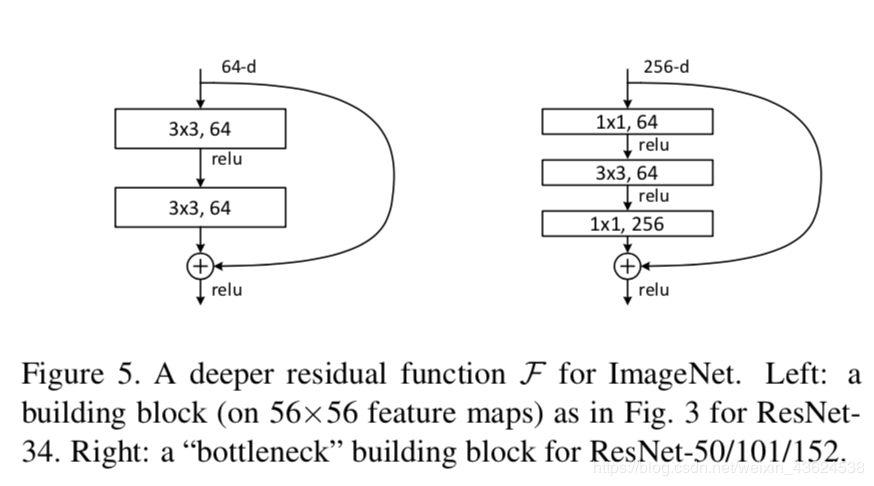

In [3]:
# 首先导入库，然后整个3x3的卷积操作和1x1的卷积操作。输入维度in_planes，输出维度out_planes步长都为
import torch
import torch.nn as nn


__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152', 'resnext50_32x4d', 'resnext101_32x8d',
           'wide_resnet50_2', 'wide_resnet101_2']


def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

In [4]:
# 然后开始定义卷积块
# 首先init一些必要参数，其中inplanes和planes是输入输出维度，其他的顾名思义很简单都是卷积用的操作
# 然后三个if语句判断几个参数别整错了
# 然后开始定义几个层，很简单，把该传的参数传进去就行了
# 然后使用定义好的层，进行前向计算：卷积>归一化>激活函数>卷积>归一化>下采样（如果有）>输出与x相加>激活函数>输出
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)
        # 有一说一这样写确实很方便而且好理解
        out += identity
        out = self.relu(out)

        return out


定义完基础的卷积块后，开始构建通用的resnet基础类，方便后续进行调用啥的

In [5]:
# 比较难理解参数有点多
# 
class ResNet(nn.Module):
    
    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        # 判断一下是否归一化，默认是进行归一化的
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer
        # 输入维度，可以看到表格第一个卷积块的第一个卷积操作都是64的输出维度
        # dilation是卷积相隔元素，一般来说是默认1
        self.inplanes = 64
        self.dilation = 1
        # 元组中的每个元素都指示我们是否应该用扩展的卷积替换2x2步长，就是一个替换不懂的去看看dilation啥概念，如果有时间我会在此更新
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        # 没啥特殊，组卷积是1，如果后续传入参数就进行相应更改
        self.groups = groups
        # 每个组卷积的深度默认64，具体啥意思往下看
        self.base_width = width_per_group
        # 先整个基础的卷积就是开头的第一个卷积，
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        # 归一化
        self.bn1 = norm_layer(self.inplanes)
        # 激活函数
        self.relu = nn.ReLU(inplace=True)
        # 最大池化
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        # 下面开整主体结构了，显然为了方便作者将构建的过程写成了一个函数_make_layes我们先去看看都干了啥
        # 请先看下面的_make_layes函数。
        # layesr意思是每一个卷积块有几层卷积比如看图resnet18 就是2 2 2 2很简单
        self.layer1 = self._make_layer(block, 64, layers[0])
        # dilate=replace_stride_with_dilation[0]判断是不是要替换，一般来说不需要，如果你需要更改传入相关参数即可
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        # 构建完以后做一个平均池化到1x1
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        # 最后再整一个全连接层，到此网络就完事了
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        # 初试化一下参数
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
        # 一个改进方法，附上论文了感兴趣去看看
        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    # 书接上回，来看看怎么新建卷积块的
    # 首先第一个参数block就是传入啥结构是BasicBlock还是Bottleneck，然后就是输出维度然后blocks是有几个层，我猜是，后面可以看看
    # 
    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        # 归一化、下采样的老一套，
        norm_layer = self._norm_layer
        downsample = None
        # 如果不修改的话是1
        previous_dilation = self.dilation
        # 修改dilation的这一块没看懂干啥的
        if dilate:
            self.dilation *= stride
            stride = 1
        # 判断一些参数步长是不是1，block.expansion是1，这个判断论文有介绍看看输出维度和输入维度是否相等不相等就整个1x1的卷积作为下采样操作。
        # 不懂得看看论文，为啥要下采样到大小一样我估计是为了后面相加的时候维度能一样
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )
        # 开始定义需要的层了
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        # 改写输入维度和上一层的输出维度一样
        self.inplanes = planes * block.expansion
        # blocks的意义就是定义一个卷积块
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))
        # 最后定义好主体的层后就完事了，可以去接下来的卷积块了
        return nn.Sequential(*layers)
    # 定义前向计算，全部完成
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        # 这就是主要结构
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

In [6]:
# 定义一个通用的resnet模型获取函数，没啥需要改参数的就是看看需不需要加载预训练参数
def _resnet(arch, block, layers, pretrained, progress, **kwargs):
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model

# 终于可以获取到最终的网络了，不容易
def resnet18(pretrained=False, progress=True, **kwargs):
    r"""ResNet-18 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet18', BasicBlock, [2, 2, 2, 2], pretrained, progress,
                   **kwargs)

In [7]:
# 数据加载在最上面 不太方便凑合看 后续改改排版
model = resnet18(num_classes=10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
epochs = 1
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

为了代码整洁我就不训练了，把训练的那一块代码模型一换就完事了，cifar10专题部分到这就告一段落了，对模型感兴趣的读者可以去看看论文.